<a href="https://colab.research.google.com/github/halisson-gomides/IESB/blob/main/fundamentos_ia/trabalho_final/hg_trabalho_final_IA_fundamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### ESPECIALIZAÇÃO EM INTELIGÊNCIA ARTIFICIAL
#### FUNDAMENTOS DE INTELIGÊNCIA ARTIFICIAL - 2022/01

Professora: Tatiana S. Tavares

Aluno: Halisson Souza Gomides



---



**Contexto**

Os depósitos a prazo são uma importante fonte de renda para um banco. Um depósito a prazo é um investimento em dinheiro mantido em uma instituição financeira. Seu dinheiro é investido por uma taxa de juros acordada por um período fixo de tempo ou prazo. O banco tem vários planos de divulgação para vender depósitos a prazo para seus clientes, como email marketing, anúncios, marketing telefônico e marketing digital.

As campanhas de marketing por telefone ainda continuam sendo uma das maneiras mais eficazes de alcançar as pessoas. No entanto, eles exigem um grande investimento, pois grandes call centers são contratados para realmente executar essas campanhas. Portanto, é crucial identificar os clientes com maior probabilidade de conversão com antecedência, para que eles possam ser direcionados especificamente por meio de chamadas.

Os dados dizem respeito a campanhas de marketing direto (telefonemas) de uma instituição bancária portuguesa. O objetivo da classificação é prever se o cliente irá subscrever um depósito a prazo (variável y).
<br><br>

**Conteúdo**

>Os dados estão relacionados com as campanhas de marketing direto de uma instituição bancária portuguesa. As campanhas de marketing foram baseadas em telefonemas. Muitas vezes, era necessário mais de um contato com o mesmo cliente, para acessar se o produto (depósito a prazo bancário) seria ('sim') ou não ('não') subscrito pelo cliente ou não.



## Ambiente

In [1]:
%%capture
!pip install -U scikit-optimize

In [2]:
# Manipulação de Dados
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Separação dos dados em treino e teste
from sklearn.model_selection import train_test_split

# Seleção de Atributos
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Modelos de Classificação
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Validação cruzada
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Métricas
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import RocCurveDisplay

# Tuning de hiperparâmetros
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# Acessórias
import time
import joblib

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Funções úteis

In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Seu dataframe possui " + str(df.shape[1]) + " colunas.\n"      
            "Existem " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que possuem valores ausentes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Coleta dos dados

In [6]:
df_raw = pd.read_csv('/content/bank.csv')
df_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Análise inicial dos dados

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


#### Verificando a cardinalidade das variáveis categóricas

In [8]:
for col in df_raw.select_dtypes(include='O').columns:
  print(col)
  display(df_raw[col].value_counts(dropna=False))
  print(format('','*^82'))

job


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

**********************************************************************************
marital


married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

**********************************************************************************
education


secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

**********************************************************************************
default


no     10994
yes      168
Name: default, dtype: int64

**********************************************************************************
housing


no     5881
yes    5281
Name: housing, dtype: int64

**********************************************************************************
loan


no     9702
yes    1460
Name: loan, dtype: int64

**********************************************************************************
contact


cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

**********************************************************************************
month


may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: month, dtype: int64

**********************************************************************************
poutcome


unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

**********************************************************************************
deposit


no     5873
yes    5289
Name: deposit, dtype: int64

**********************************************************************************


#### Descrição das variáveis do dataset

1. age (numérico)
2. job : tipo de ocupação (categórico: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
3. marital : estado civil (categórico: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categórico: "unknown","secondary","primary","tertiary")
5. default: tem empréstimo em atraso? (binário: "yes","no")
6. balance: saldo anual médio, em euros (numérico)
7. housing: tem financiamento imobiliário? (binário: "yes","no")
8. loan: tem empréstimo pessoal? (binary: "yes","no")
#### relacionado com o último contato da campanha atual:
9. contact: tipo de contato realizado (categórico: "unknown","telephone","cellular")
10. day: último dia de contato do mês (numérico)
11. month: último mês de contato do ano (categórico: "jan", "feb", "mar", …, "nov", "dec")
12. duration: duração do útimo contato, em segundos (numerico)
#### outros atributos:
13. campaign: número de contatos realizados durante esta campanha e para este cliente (numerico, incluindo o último contato)
14. pdays: número de dias que se passaram depois que o cliente foi contatado pela última vez em uma campanha anterior (numerico, -1 significa que o cliente não foi previamente contatado)
15. previous: número de contatos realizados antes desta campanha e para este cliente (numerico)
16. poutcome: resultado da campanha de marketing anterior (categorico: "unknown","other","failure","success")

#### verificando valores ausentes

In [9]:
missing_values_table(df_raw)

Seu dataframe possui 17 colunas.
Existem 0 colunas que possuem valores ausentes.


,Missing Values,% of Total Values


### verificando registros duplicados

In [10]:
df_raw.duplicated().sum()

0

#### Transformação de variáveis

In [11]:
df = df_raw.copy()

Criei uma nova feature `difficulty` que pretende expressar a dificuldade do banco em fazer o cliente aderir à campanha.

In [12]:
df['difficulty'] = -1 # desconhecido
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(0,1)), 'difficulty'] = 0 #fácil
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(2,4)), 'difficulty'] = 1 #médio
df.loc[(df['poutcome'] == 'success') & (df['previous'].between(5,7)), 'difficulty'] = 2 #difícil
df.loc[(df['poutcome'] == 'success') & (df['previous'] > 7), 'difficulty'] = 3 # muito difícil
df.loc[df['poutcome'] == 'failure', 'difficulty'] = 4 # impossível

In [13]:
df['difficulty'].value_counts()

-1    8863
 4    1228
 1     525
 0     326
 2     146
 3      74
Name: difficulty, dtype: int64

### Seleção de variáveis

Variáveis explicativas

In [14]:
vars_explicativas = df.drop('deposit', axis=1).columns
df[vars_explicativas].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,difficulty
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,-1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,-1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,-1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,-1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,-1


In [15]:
df[vars_explicativas].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         11162 non-null  int64 
 1   job         11162 non-null  object
 2   marital     11162 non-null  object
 3   education   11162 non-null  object
 4   default     11162 non-null  object
 5   balance     11162 non-null  int64 
 6   housing     11162 non-null  object
 7   loan        11162 non-null  object
 8   contact     11162 non-null  object
 9   day         11162 non-null  int64 
 10  month       11162 non-null  object
 11  duration    11162 non-null  int64 
 12  campaign    11162 non-null  int64 
 13  pdays       11162 non-null  int64 
 14  previous    11162 non-null  int64 
 15  poutcome    11162 non-null  object
 16  difficulty  11162 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 1.4+ MB


Variável Resposta

In [16]:
# Variável Resposta
var_resp = 'deposit'
df[[var_resp]].value_counts()

deposit
no         5873
yes        5289
dtype: int64

In [17]:
# Encoding da variável resposta
df[var_resp] = df[var_resp].apply(lambda x: 0 if x == 'no' else 1)
df[[var_resp]].value_counts()

deposit
0          5873
1          5289
dtype: int64

In [18]:
# explicativas numéricas
vars_expl_num = df[vars_explicativas].select_dtypes(exclude='O').columns.difference(['difficulty'])
vars_expl_num

Index(['age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous'], dtype='object')

In [19]:
# explicativas categóricas
vars_expl_cat = df[vars_explicativas].columns.difference(vars_expl_num)
vars_expl_cat

Index(['contact', 'default', 'difficulty', 'education', 'housing', 'job',
       'loan', 'marital', 'month', 'poutcome'],
      dtype='object')

#### Seleção de features categóricas

In [20]:
# chi2 - aplicação do método chi2 para seleção de features categóricas

# 1. Encondig das variáveis categóricas
df_expl_cat_enc = pd.get_dummies(df[vars_expl_cat], columns=vars_expl_cat, drop_first=True)

# 2. Ajuste de escala
expl_cat_norm = MinMaxScaler().fit_transform(df_expl_cat_enc)

# 3. Aplicação da técnica
chi_selector = SelectKBest(chi2, k=5)
chi_selector.fit(expl_cat_norm, df[var_resp])

SelectKBest(k=5, score_func=<function chi2 at 0x7f85119b2e60>)

*Nota:* Lembrando que o teste do qui-quadrado mede a dependência entre variáveis estocásticas, portanto, usar essa função _“elimina”_ as features que são mais prováveis de serem independentes da variável target e, portanto, irrelevantes para a classificação.

In [21]:
chi_support = chi_selector.get_support()
chi_feature = df_expl_cat_enc.loc[:,chi_support].columns.tolist()
chi_feature

['contact_unknown',
 'difficulty_0',
 'difficulty_1',
 'housing_yes',
 'poutcome_success']

*Nota*: no caso, o método do chi2 selecionou algumas categorias de algumas features. Daí, o correto é entendermos que devemos usar as features `contact`, `difficulty`, `housing` e `poutcome` como um todo, ao invés de apenas suas categorias selecionadas.

#### Seleção de features numéricas

In [22]:
# RFE - aplicação do método recursive feature elimination (rfe) para seleção de features numéricas

# 1. Ajuste de escala
expl_num_norm = MinMaxScaler().fit_transform(df[vars_expl_num])

# 2. Aplicação da técnica
rfe_selector = RFE(estimator=LogisticRegression(random_state=42, max_iter=200), n_features_to_select=3, step=1)
rfe_selector.fit(expl_num_norm, df[var_resp])

RFE(estimator=LogisticRegression(max_iter=200, random_state=42),
    n_features_to_select=3)

*Nota:* Dado um algoritmo externo que atribui pesos às features (por exemplo, os coeficientes de um modelo linear), o objetivo da eliminação recursiva de recursos (RFE) é selecionar features considerando recursivamente conjuntos cada vez menores de features. Primeiro, o algoritmo é treinado no conjunto inicial de features e a importância de cada feature é obtida. Em seguida, as features menos importantes são removidas do conjunto atual de features. Esse procedimento é repetido recursivamente no conjunto de dados até que o número desejado de features a serem selecionadas seja finalmente alcançado.

In [23]:
rfe_support = rfe_selector.get_support()
rfe_feature = df[vars_expl_num].loc[:,rfe_support].columns.tolist()
rfe_feature

['campaign', 'duration', 'previous']



### ABT - Analytical Base Table
 Base a ser considerada no processo de modelagem

In [24]:
categorical_columns_subset = ['contact','difficulty','housing','poutcome']
df_features_model = df[rfe_feature + categorical_columns_subset].copy()
df_features_model[categorical_columns_subset] = df_features_model[categorical_columns_subset].astype('category')
df_features_model.head()

,campaign,duration,previous,contact,difficulty,housing,poutcome
0,1,1042,0,unknown,-1,yes,unknown
1,1,1467,0,unknown,-1,no,unknown
2,1,1389,0,unknown,-1,yes,unknown
3,1,579,0,unknown,-1,yes,unknown
4,2,673,0,unknown,-1,no,unknown


In [25]:
df_features_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   campaign    11162 non-null  int64   
 1   duration    11162 non-null  int64   
 2   previous    11162 non-null  int64   
 3   contact     11162 non-null  category
 4   difficulty  11162 non-null  category
 5   housing     11162 non-null  category
 6   poutcome    11162 non-null  category
dtypes: category(4), int64(3)
memory usage: 306.0 KB


### Modelagem

#### Separação em dados de treino e teste

In [26]:
# Separação em dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_features_model, df[var_resp], test_size=0.3, random_state=42)

#### Pipeline

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

Função que cria um pipeline sequencial de preprocessamento e modelagem dos dados, que é treinado e retorna os scores de cross-validation.

Caso sejam passados para a função o parâmetro `params` (dicionário de hiperparâmetros a serem testados), ela executa o Tunning de hiperparâmetros utilizando o otimizador `BayesSearchCV` da biblioteca scikit-optimize, e retorna modelo treinado com os melhores hiperparâmetros selecioados pelo otimizador.

In [28]:
def modelagem(model, X_sample, y_sample, score="accuracy", params=False):
  # Start time count
  start = time.time()
  
  # Pipeline de pre-processamento
  preprocess = ColumnTransformer([
                                  ('numerical_transformer', MinMaxScaler(), make_column_selector(dtype_include='int64')),
                                  ('categorical_transformer', OneHotEncoder(drop='first', handle_unknown='ignore'), make_column_selector(dtype_include='category'))
  ], remainder='passthrough')

  # Pipeline de modelagem
  model_pipeline = Pipeline([('preprocess', preprocess),
                       ('model', model)])
  
  # Stratified Cross Validation 
  n_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
  if not params:
    results = cross_val_score(model_pipeline, X_sample, y_sample, cv=n_cv, scoring=score, n_jobs=-1)    
    # End time count
    final = time.time() - start
    minutes = int(final/60)
    seconds_diff = final - (minutes*60)
    print(f'Tempo decorrido: {minutes:.0f} minutos e {seconds_diff:.0f} segundos para a modelagem.')    
    return results
  
  # elif model.__class__.__name__ == 'MLPClassifier':
  #   @use_named_args(params)
  #   def evaluate_model(**params):      
  #     params['hidden_layer_sizes'] = (params['n_neurons_per_layer'],)*params['n_hidden_layer']
  #     params.pop('n_neurons_per_layer')
  #     params.pop('n_hidden_layer')       
  #     model.set_params(**params)      
  #     results = cross_val_score(model_pipeline, X_sample, y_sample, cv=n_cv, scoring=score, n_jobs=-1)
  #     return results.mean()

  #   result = gp_minimize(evaluate_model, params, n_calls=36, n_jobs=-1, random_state=42)
  #   final = time.time() - start
  #   print(f'Time to run: {final:.2f} seconds for modeling.')
  #   return result

  # Params Search
  bayes_search = BayesSearchCV(model_pipeline, search_spaces=params, cv=n_cv, scoring=score, n_jobs=-1, n_iter=36, verbose=10)

  # Search Result
  result = bayes_search.fit(X_sample, y_sample)

  # End time count
  final = time.time() - start
  minutes = int(final/60)
  seconds_diff = final - (minutes*60)
  print(f'Tempo decorrido: {minutes:.0f} minutos e {seconds_diff:.0f} segundos para a modelagem.')

  return result



*_Nota_*: BayesSearchCV - Essa abordagem usa otimização bayesiana passo a passo para explorar os hiperparâmetros mais promissores no espaço do problema.

#### Instanciamento dos Modelos e definição de parâmetros

In [ ]:
# Multi-layer Perceptron classifier
nn_model = MLPClassifier(random_state=42)

#  Multi-layer Perceptron Parameters    
# nn_param_seach_space = [
#                         Integer(1, 3, name='n_hidden_layer'),
#                         Integer(200, 250, name='n_neurons_per_layer'),
#                         Categorical(['identity', 'logistic', 'tanh', 'relu'], name='activation'),
#                         Categorical(['lbfgs', 'sgd', 'adam'], name='solver'),
#                         Real(1e-6, 1e-2, prior='log-uniform', name='alpha'),
#                         Categorical(['constant', 'invscaling', 'adaptive'], name='learning_rate')]

nn_param_seach_space =   {"model__activation": Categorical(['identity', 'logistic', 'tanh', 'relu']),
                          "model__solver": Categorical(['lbfgs', 'sgd', 'adam']),                          
                          "model__alpha": Real(1e-6, 1e-2, prior='log-uniform'),
                          "model__learning_rate": Categorical(['constant', 'invscaling', 'adaptive'])}

In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(bootstrap=True, random_state=42)

# Random Forest Parameters   
rf_param_seach_space = {"model__min_samples_leaf": Integer(2, 30, prior='uniform'),
                          "model__min_samples_split": Integer(2, 20, prior='uniform'),
                          "model__max_depth": Integer(2, 10000, prior='log-uniform'),
                          "model__n_estimators": Integer(2, 10000, prior='log-uniform'),
                          "model__max_samples": Real(0.05, 0.5),
                          "model__criterion": Categorical(["gini", "entropy"])}

In [ ]:
# XGB CLassifier Model
xgbc_model = GradientBoostingClassifier(random_state=42)

# XGB Classifier Parameters
xgbc_param_seach_space = {"model__max_features": Categorical([None,'sqrt', 'log2']),
                            "model__criterion": Categorical(["friedman_mse","squared_error"]),
                            "model__learning_rate": Real(0.1, 0.5),
                            "model__n_estimators": Integer(50,200),
                            "model__ccp_alpha": Real(0.0, 0.2),
                            "model__max_depth": Integer(2, 10000, prior='log-uniform'),}

#### Baseline

In [ ]:
nn_base = modelagem(nn_model, x_train, y_train)
print("Average accuracy: %f +- %f" %(nn_base.mean(), nn_base.std()))

Tempo decorrido: 0 minutos e 24 segundos para a modelagem.
Average accuracy: 0.804174 +- 0.012217


In [ ]:
rf_base = modelagem(rf_model, x_train, y_train)
print("Average accuracy: %f +- %f" %(rf_base.mean(), rf_base.std()))

Tempo decorrido: 0 minutos e 3 segundos para a modelagem.
Average accuracy: 0.748239 +- 0.015898


In [ ]:
xgbc_base = modelagem(xgbc_model, x_train, y_train)
print("Average accuracy: %f +- %f" %(xgbc_base.mean(), xgbc_base.std()))

Tempo decorrido: 0 minutos e 2 segundos para a modelagem.
Average accuracy: 0.808397 +- 0.009530


#### Tunning de parâmetros

In [ ]:
nn_tunned = modelagem(nn_model, x_train, y_train, params=nn_param_seach_space)
print('')
print(format('Multi-layer Perceptron classifier after hyperparameters tunning','*^82'))
print(f'Accuracy for train set: {nn_tunned.best_score_:.4f}')
print(f'Accuracy for test set: {nn_tunned.score(x_test, y_test):.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo decorrido: 11 minutos e 31 segundos para a modelagem.

*********Multi-layer Perceptron classifier after hyperparameters tunning**********
Accuracy for train set: 0.8049
Accuracy for test set: 0.7996


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
rf_tunned = modelagem(rf_model, x_train, y_train, params=rf_param_seach_space)
print('')
print(format(f'{rf_model.__class__.__name__} after hyperparameters tunning','*^82'))
print(f'Accuracy for train set: {rf_tunned.best_score_:.4f}')
print(f'Accuracy for test set: {rf_tunned.score(x_test, y_test):.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo decorrido: 29 minutos e 45 segundos para a modelagem.

***************RandomForestClassifier after hyperparameters tunning***************
Accuracy for train set: 0.8080
Accuracy for test set: 0.8029


In [ ]:
xgbc_tunned = modelagem(xgbc_model, x_train, y_train, params=xgbc_param_seach_space)
print('')
print(format(f'{xgbc_model.__class__.__name__} after hyperparameters tunning','*^82'))
print(f'Accuracy for train set: {xgbc_tunned.best_score_:.4f}')
print(f'Accuracy for test set: {xgbc_tunned.score(x_test, y_test):.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo decorrido: 5 minutos e 10 segundos para a modelagem.

*************GradientBoostingClassifier after hyperparameters tunning*************
Accuracy for train set: 0.8053
Accuracy for test set: 0.8023


#### Salva o melhor modelo

In [ ]:
joblib.dump(rf_tunned, 'rf_tunned.pkl')

['rf_tunned.pkl']

In [ ]:
nn_model = joblib.load('nn_tunned.pkl')
rf_model = joblib.load('rf_tunned.pkl')
xgbc_model = joblib.load('xgbc_tunned.pkl')

nn_bestmodel = nn_model.best_estimator_
rf_bestmodel = rf_model.best_estimator_
xgbc_bestmodel = xgbc_model.best_estimator_

In [ ]:
df_metricas = pd.DataFrame([
                            [accuracy_score(y_test, nn_bestmodel.predict(x_test)),roc_auc_score(y_test, nn_bestmodel.predict(x_test))],
                            [accuracy_score(y_test, rf_bestmodel.predict(x_test)),roc_auc_score(y_test, rf_bestmodel.predict(x_test))],
                            [accuracy_score(y_test, xgbc_bestmodel.predict(x_test)),roc_auc_score(y_test, xgbc_bestmodel.predict(x_test))],                            
                            ])
df_metricas.columns = ['Accuracy', 'ROC_AUC']
df_metricas.index = ['MLPClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

In [ ]:
df_metricas.sort_values(by='Accuracy', ascending=False)

,Accuracy,ROC_AUC
MLPClassifier,0.804121,0.804260
RandomForestClassifier,0.802926,0.802774
GradientBoostingClassifier,0.802329,0.801718


In [ ]:
#@title parâmetros de formatação dos gráficos {display-mode: "form"}
import plotly.graph_objects as go

plotly_kwargs = dict(
    title_x=0.5,
    autosize=False,
    plot_bgcolor='white',
    margin=dict(l=2, r=10, t=30, b=2),
    width=800,
    height=400,
    hovermode='x unified',
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    )
)

In [ ]:
fig = go.Figure()
colors = ['rgb(49,130,189)', 'rgb(115,115,115)', 'rgb(189,189,189)']
labels = ['MLP', 'RandomForest', 'GradientBoosting']
line_sizes = [4, 2, 2]
spaces = [-8,1,0]
annotations = []

for line_size, label, color, space in zip(line_sizes, labels, colors, spaces):
  fig.add_trace(go.Scatter(x=df_metricas.T.index, y=df_metricas.T[f'{label}Classifier'], name=label,
                          line=dict(color=color, width=line_size), line_shape='spline'))
  annotations.append(dict(xref='paper', x=0.95, y=df_metricas.T[f'{label}Classifier'][-1],
                                  xanchor='left', yanchor='middle',
                                  text=label, yshift=space,
                                  font=dict(family='Arial',size=16, color=color),
                                  showarrow=False))

fig.update_traces(hovertemplate=None, mode='lines+markers')
fig.update_layout(title=f'<b>Comparação de métricas</b>', **plotly_kwargs)
fig.update_layout(margin=dict( autoexpand=False,r=150, l=50, b=50))
fig.update_layout(showlegend=False, hovermode="x", annotations=annotations)
fig.show()

#### Avaliação do melhor modelo

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

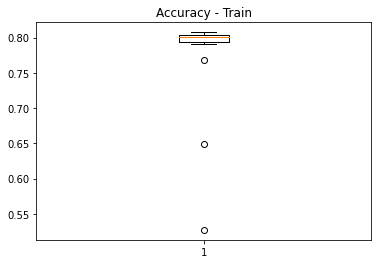


AUC score:  0.8042599576908431

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1742
           1       0.79      0.81      0.80      1607

    accuracy                           0.80      3349
   macro avg       0.80      0.80      0.80      3349
weighted avg       0.80      0.80      0.80      3349


-----------------------------------------------------------------------



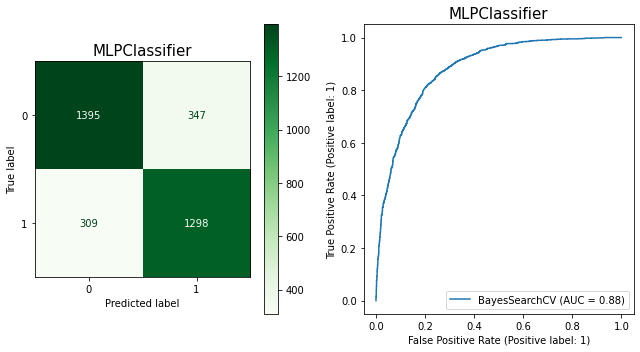

In [ ]:
y_true, y_pred = y_test , nn_model.predict(x_test)
clf = nn_model
classifier_name = clf.best_estimator_['model'].__class__.__name__ # modelo com melhor acurácia
cv_results = clf.cv_results_

plt.boxplot(cv_results['mean_test_score'])
plt.title('Accuracy - Train')
plt.show()

print('')

print('AUC score: ', roc_auc_score(y_true, y_pred))
print('')
print(classification_report(y_test, y_pred))
print('')
print('-----------------------------------------------------------------------')
print('')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, values_format='d', cmap='Greens', ax=ax1)
ax1.set_title(classifier_name,fontsize=15);
plt.grid(False)
RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=ax2);
ax2.set_title(classifier_name,fontsize=15);
plt.tight_layout()
plt.show()